# MS2 analysis

Jupyter notebook containing analyses for evaluating impact of MS2 and WPRE on barcode capture in nuclei datasets from Shin & Urbanek. 

Input for this analysis requires:

1) Cell barcode list for all cells passing transcriptome QC (nCount, nFeature, and mitochondrial% thresholding) per dataset
2) Rabies barcode count matrices with cell barcodes for each dataset
3) Flat.txt files normally input into UMI_tools, which will allow you to calculate barcode reads per library

Output for this analysis includes:

1) Plot showing relationships between barcode UMIs and reads per cell
2) Bar plot showing the fraction of each library with a certain number of barcode UMIs

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was last amended by Maddie Urbanek on 12/12/2025

## Notebook set-up

In [115]:
#Load in modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy import stats
from scipy.stats import ranksums
from itertools import product
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
from matplotlib.ticker import PercentFormatter

In [98]:
#Set working directory to point to barcode diversity libraries
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/fastqs/slice_experiments/ms2_comparison/')

## Import datasets

Import filtered cell barcode lists generated in transcriptome_qc_doublet_filtering.rmd

In [99]:
no_txn=pd.read_table('../../../transcriptome/cellbarcode_lists/no_ms2.csv',delimiter=',')
ms2_txn=pd.read_table('../../../transcriptome/cellbarcode_lists/ms2_wpre.csv',delimiter=',')

Import rabies barcode count matrices

In [100]:
no_bcs=pd.read_table('./no_ms2/bc/completecounts.tsv',delimiter='\t')
ms2_bcs=pd.read_table('./ms2_wpre/bc/completecounts.tsv',delimiter='\t')

Import flat.txt files for each library

In [101]:
no_flat=pd.read_table('./no_ms2/bc/flat.txt',delimiter='\t',header=None)
ms2_flat=pd.read_table('./ms2_wpre/bc/flat.txt',delimiter='\t',header=None)

### Filter barcode data down to real cells

Barcode UMI count files:

In [102]:
#MS2
ms2_bcs['CBC'] = ms2_bcs['CBC'].str.replace('b', '', regex=True)
ms2_bcs['CBC'] = ms2_bcs['CBC'].str.replace('\'', '', regex=True)
ms2_bcs['CBC'] = 'wpre_' + ms2_bcs['CBC'].astype(str)
ms2_bcs=ms2_bcs.sort_values('CBC')
ms2=ms2_bcs.loc[ms2_bcs['CBC'].isin(ms2_txn.x)]
ms2

#No MS2
no_bcs['CBC'] = no_bcs['CBC'].str.replace('b', '', regex=True)
no_bcs['CBC'] = no_bcs['CBC'].str.replace('\'', '', regex=True)
no_bcs['CBC'] = 'no_ms2_' + no_bcs['CBC'].astype(str)
no_bcs=no_bcs.sort_values('CBC')
no_ms2=no_bcs.loc[no_bcs['CBC'].isin(no_txn.x)]
ms2

,CBC,barcode,UMI_Count
67258,wpre_AAAAAAAAATGGAAGA,barcode,8
4222,wpre_AAAAAAAGCAGCCATG,barcode,42
24610,wpre_AAAAACGTCAGACAAA,barcode,17
17423,wpre_AAAAAGCGAGTTCAGG,barcode,27
22560,wpre_AAAAAGGTATTTAAAA,barcode,31
...,...,...,...
10547,wpre_CCTGAATTAGCTAGAA,barcode,8
2089,wpre_CCTGACCCAAGCATTA,barcode,38
19111,wpre_CCTGAGACCATACCTT,barcode,25
596,wpre_CCTGAGCTATTGAGTG,barcode,34


Flat barcode files:

In [103]:
#Formatting flat files
#MS2
ms2_flat[['read_id','UMI','CBC']]=ms2_flat[0].str.split('_', expand=True)
ms2_flat['CBC'] = 'wpre_' + ms2_flat['CBC'].astype(str)
ms2_flat=ms2_flat.sort_values('CBC')
ms2_filtered_flat=ms2_flat.loc[ms2_flat['CBC'].isin(ms2_txn.x)]
ms2_filtered_flat

#No MS2
no_flat[['read_id','UMI','CBC']]=no_flat[0].str.split('_', expand=True)
no_flat['CBC'] = 'no_ms2_' + no_flat['CBC'].astype(str)
no_flat=no_flat.sort_values('CBC')
no_filtered_flat=no_flat.loc[no_flat['CBC'].isin(no_txn.x)]
no_filtered_flat


,0,1,read_id,UMI,CBC
904381,VH00874:168:AACKG5GHV:2:2503:56064:54198_AAAAA...,barcode,VH00874:168:AACKG5GHV:2:2503:56064:54198,AAAAAAACCAAACCCGCATACTTACAAC,no_ms2_AAAAAAACCAAACCCG
679657,VH00874:168:AACKG5GHV:2:1504:52807:51510_AAAAA...,barcode,VH00874:168:AACKG5GHV:2:1504:52807:51510,AAAAAAACCAAACCCGTGAGTGCCTGGG,no_ms2_AAAAAAACCAAACCCG
41509,VH00874:168:AACKG5GHV:1:1201:33948:2136_AAAAAA...,barcode,VH00874:168:AACKG5GHV:1:1201:33948:2136,AAAAAAACCAAACCCGAAAGGATGCTAA,no_ms2_AAAAAAACCAAACCCG
41429,VH00874:168:AACKG5GHV:1:1201:32016:3007_AAAAAA...,barcode,VH00874:168:AACKG5GHV:1:1201:32016:3007,AAAAAAACCAAACCCGAAAGGATGCTAA,no_ms2_AAAAAAACCAAACCCG
246514,VH00874:168:AACKG5GHV:1:1613:74924:28754_AAAAA...,barcode,VH00874:168:AACKG5GHV:1:1613:74924:28754,AAAAAAACCAAACCCGTCGGATTATATT,no_ms2_AAAAAAACCAAACCCG
...,...,...,...,...,...
605513,VH00874:168:AACKG5GHV:2:1306:74659:20613_CCTGC...,barcode,VH00874:168:AACKG5GHV:2:1306:74659:20613,CCTGCCTGACTTACACTGATAAATATCG,no_ms2_CCTGCCTGACTTACAC
945600,VH00874:168:AACKG5GHV:2:2604:26809:27599_CCTGC...,barcode,VH00874:168:AACKG5GHV:2:2604:26809:27599,CCTGCCTGACTTACACGTATGAATGTTC,no_ms2_CCTGCCTGACTTACAC
677553,VH00874:168:AACKG5GHV:2:1503:70891:25176_CCTGC...,barcode,VH00874:168:AACKG5GHV:2:1503:70891:25176,CCTGCCTGACTTACACATGTATAACGTG,no_ms2_CCTGCCTGACTTACAC
921196,VH00874:168:AACKG5GHV:2:2509:55023:8630_CCTGCC...,barcode,VH00874:168:AACKG5GHV:2:2509:55023:8630,CCTGCCTGACTTACACATGTATAACGTG,no_ms2_CCTGCCTGACTTACAC


Generate read count files

In [104]:
no_reads=pd.DataFrame(no_filtered_flat['CBC'].value_counts())
ms2_reads=pd.DataFrame(ms2_filtered_flat['CBC'].value_counts())

### Visualization

##### Barcode UMIs vs. barcode reads per cell by dataset

In [105]:
#Merge reads and UMIs into one table
merged_ms2=pd.merge(ms2, ms2_reads, on="CBC")
merged_no=pd.merge(no_ms2, no_reads, on="CBC")
ms2_reads

,count
CBC,
wpre_ACGCCATGATTCAGGT,184
wpre_AATTCACTAGAAAAGG,164
wpre_ACATCCTGAGATCCGG,157
wpre_CAATCCGTAAAAATGC,146
wpre_ATTACATCACGTAGGG,137
...,...
wpre_AACCCAAACCAGAGAA,2
wpre_ACAACAGGCCTAATAG,2
wpre_AACGCCAACCGAATTT,2


Print some stats

In [112]:
corr_matrix = np.corrcoef(merged_no['UMI_Count'], merged_no['count'])
print(stats.spearmanr(merged_no['UMI_Count'], merged_no['count'],nan_policy="omit"))
corr = corr_matrix[0,1]
R_sq = corr**2
print('No MS2 R_squared:')
print(R_sq)
print()

corr_matrix = np.corrcoef(merged_ms2['UMI_Count'], merged_ms2['count'])
print(stats.spearmanr(merged_ms2['UMI_Count'], merged_ms2['count'],nan_policy="omit"))
corr = corr_matrix[0,1]
R_sq = corr**2
print('MS2 R_squared:')
print(R_sq)
print()


SignificanceResult(statistic=0.9273853973951471, pvalue=0.0)
No MS2 R_squared:
0.8664472503970354

SignificanceResult(statistic=0.9493853488237919, pvalue=0.0)
MS2 R_squared:
0.885051023249871



Plot

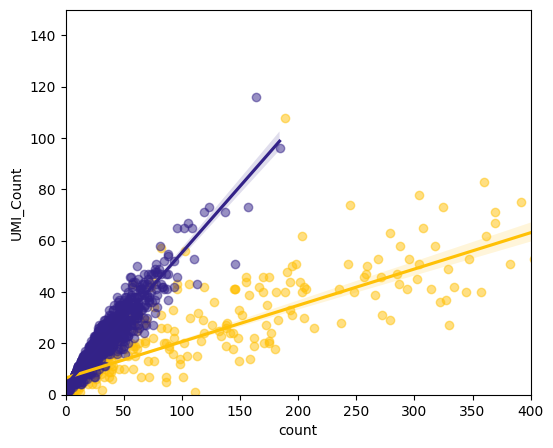

In [94]:
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(data=merged_no, x='count', y='UMI_Count', color = '#FFC107',scatter_kws={'alpha':0.5},label='No MS2')
sns.regplot(data=merged_ms2, x='count', y='UMI_Count', color = '#332288',scatter_kws={'alpha':0.5},label='MS2+WPRE')
ax.set_xlim(0, 400)
ax.set_ylim(0, 150)

ax.figure.savefig("../../../../figs/fig_6/ms2_reads_comparison.pdf")

##### Distribution of barcode UMIs per dataset

Print some stats

In [116]:
#Make UMI count-summed dataframes
print()
print('Wilcoxon Ranked Sum to compare distributions:')

print('No MS2 mean:')
print((merged_no['UMI_Count'].mean()))
print('No MS2 median:')
print((merged_no['UMI_Count'].median()))
print('No MS2 SEM:')
print(merged_ms2['UMI_Count'].sem())
print('MS2 mean:')
print(merged_ms2['UMI_Count'].mean())
print('MS2 median:')
print((merged_ms2['UMI_Count'].median()))
print('MS2 SEM:')
print(merged_ms2['UMI_Count'].sem())

print('Wilcoxon Ranked Sum Results:')
print(ranksums(merged_no['UMI_Count'], merged_ms2['UMI_Count']))


Wilcoxon Ranked Sum to compare distributions:
No MS2 mean:
12.52720207253886
No MS2 median:
8.0
No MS2 SEM:
0.3539613774111454
MS2 mean:
19.0895390070922
MS2 median:
17.0
MS2 SEM:
0.3539613774111454
Wilcoxon Ranked Sum Results:
RanksumsResult(statistic=-22.09527126071078, pvalue=3.50956143062281e-108)


Plot

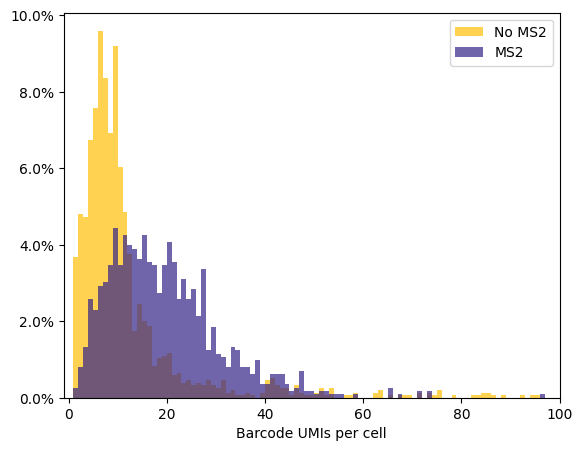

In [95]:
plt.figure().set_figheight(5)
plt.hist(merged_no['UMI_Count'],bins=np.arange(0,merged_no['UMI_Count'].max() + 5, 1),color='#FFC107',alpha=0.7,label='No MS2',weights=np.ones(len(merged_no['UMI_Count'])) / len(merged_no['UMI_Count']))
plt.hist(merged_ms2['UMI_Count'],bins=np.arange(0, merged_ms2['UMI_Count'].max() + 5, 1),color='#332288',alpha=0.7,label='MS2',weights=np.ones(len(merged_ms2['UMI_Count'])) / len(merged_ms2['UMI_Count']))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Barcode UMIs per cell')
#plt.ylabel('Frequency')
plt.xlim([-1, 100])
#plt.ylim([0,100])
#plt.yscale('log')
plt.legend()
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../../../../figs/fig_6/ms2_distributions.pdf', bbox_inches='tight', format='pdf')
plt.show()

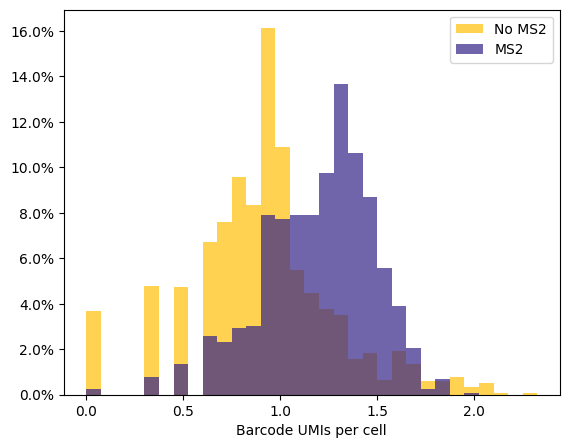

In [96]:
#After UMI thresholding, after assigning to real cells
plt.figure().set_figheight(5)
plt.hist(np.log10(merged_no['UMI_Count']),bins=np.arange(0,np.log10(merged_no['UMI_Count']).max() + .01, .075),color='#FFC107',alpha=0.7,label='No MS2',weights=np.ones(len(merged_no['UMI_Count'])) / len(merged_no['UMI_Count']))
plt.hist(np.log10(merged_ms2['UMI_Count']),bins=np.arange(0, np.log10(merged_ms2['UMI_Count']).max() + .01, .075),color='#332288',alpha=0.7,label='MS2',weights=np.ones(len(merged_ms2['UMI_Count'])) / len(merged_ms2['UMI_Count']))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Barcode UMIs per cell')
#plt.ylabel('Frequency')
#plt.xlim([-1, 100])
#plt.ylim([0,100])
#plt.yscale('log')
plt.legend()
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../../../../figs/fig_6/log_ms2_distributions.pdf', bbox_inches='tight', format='pdf')
plt.show()